In [35]:
from pynq import Overlay, allocate
import numpy as np

In [36]:
overlay = Overlay('/home/xilinx/pynq/overlays/grayscale/grayscale.bit')

In [37]:
grayscale = overlay.grayscale_kernel_0
dma = overlay.axi_dma_0

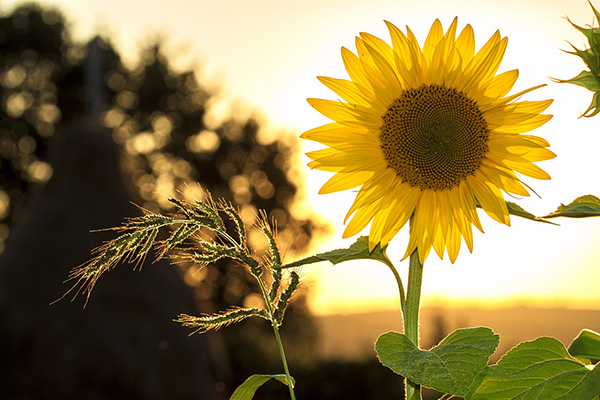

array([[15786673, 16313532, 16773830, ..., 16772304, 16772813, 16052937],
       [15918259, 16379325, 16708037, ..., 16773066, 16773322, 16381134],
       [15918513, 16313017, 16576450, ..., 16641731, 16773833, 16708047],
       ...,
       [  525568,   525568,   525568, ...,  6252288,  6445827,  4465928],
       [  591361,   591361,   591361, ...,  5527808,  7235853,  5652235],
       [  657154,   591361,   657154, ...,  5988615,  6908167,  6115086]],
      dtype=uint32)

In [40]:
in_buffer = allocate(combined_array.shape, dtype=np.uint32)
in_buffer[:] = combined_array  # Copy the combined values into the buffer

print("in_buffer shape:", in_buffer.shape)
print("First pixel in in_buffer (in hex):", hex(in_buffer[0, 0]))

out_buffer = allocate(combined_array.shape, dtype=np.uint32)

in_buffer shape: (400, 600)
First pixel in in_buffer (in hex): 0xf0e2b1


In [41]:
# in_buffer = allocate(shape=(5,), dtype=np.uint32)

In [42]:
# out_buffer = allocate(shape=(5,), dtype=np.uint32)

In [43]:
# in_buffer[0] = 0x00FF0000
# in_buffer[1] = 0x0000FF00
# in_buffer[2] = 0x000000FF
# in_buffer[3] = 0x00FFFFFF
# in_buffer[4] = 0x00808080

In [44]:
in_buffer

PynqBuffer([[15786673, 16313532, 16773830, ..., 16772304, 16772813,
             16052937],
            [15918259, 16379325, 16708037, ..., 16773066, 16773322,
             16381134],
            [15918513, 16313017, 16576450, ..., 16641731, 16773833,
             16708047],
            ...,
            [  525568,   525568,   525568, ...,  6252288,  6445827,
              4465928],
            [  591361,   591361,   591361, ...,  5527808,  7235853,
              5652235],
            [  657154,   591361,   657154, ...,  5988615,  6908167,
              6115086]], dtype=uint32)

In [45]:
width = combined_array.shape[1]
height = combined_array.shape[0]

grayscale_accel.write(0x10, width) 
grayscale_accel.write(0x18, height)

NameError: name 'grayscale_accel' is not defined

In [34]:
width

600

In [49]:
grayscale_accel.write(0x00, 1) 
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)

In [50]:
dma.sendchannel.wait()
dma.recvchannel.wait()

In [51]:
while grayscale_accel.read(0x00) & 0x4 == 0:
        pass

In [55]:
expected_values = []
print("Output values:")
for i, val in enumerate(out_buffer):
    r = (val >> 16) & 0xFF
    g = (val >> 8) & 0xFF
    b = val & 0xFF
    print(f"  Pixel {i}: R={r}, G={g}, B={b} (0x{val:08X})")

    in_val = in_buffer[i]
    in_r = (in_val >> 16) & 0xFF
    in_g = (in_val >> 8) & 0xFF
    in_b = in_val & 0xFF
    expected_gray = round(0.2126 * in_r + 0.7152 * in_g + 0.0722 * in_b)
    expected_values.append(expected_gray)

print("\nComparison with expected values:")
for i, expected in enumerate(expected_values):
    actual = out_buffer[i] & 0xFF  # Take just one channel
    print(f"  Pixel {i}: Expected={expected}, Actual={actual}, Diff={abs(expected-actual)}")

Output values:
  Pixel 0: R=18, G=18, B=18 (0x00121212)
  Pixel 1: R=182, G=182, B=182 (0x00B6B6B6)
  Pixel 2: R=54, G=54, B=54 (0x00363636)
  Pixel 3: R=255, G=255, B=255 (0x00FFFFFF)
  Pixel 4: R=128, G=128, B=128 (0x00808080)

Comparison with expected values:
  Pixel 0: Expected=54, Actual=18, Diff=36
  Pixel 1: Expected=182, Actual=182, Diff=0
  Pixel 2: Expected=18, Actual=54, Diff=36
  Pixel 3: Expected=255, Actual=255, Diff=0
  Pixel 4: Expected=128, Actual=128, Diff=0
